In [1]:
import os, sys, time, datetime, json, random
import numpy as np
import copy
import matplotlib.pyplot as plt
%matplotlib inline

- 0 - 左
- 1 - 向上
- 2 - 右
- 3 - 向下
- 每次移动都会花费老鼠 -0.04 分
- 奶酪，给予 1.0 分
- 封锁的单元格-0.75 分，动作不会被执行
- 迷宫边界之外的行为：-0.8 分，动作不会被执行
- 已经访问过的单元格，-0.25 分
- 总奖励低于负阈值：(-0.5 * maze.size)，lose

In [69]:
def generate_gridworld(n, prob):
    """
    生成大小为n x n的随机Gridworld，其中prob控制1出现的频率。
    返回值是一个包含n个列表的列表，每个列表包含n个随机数（0或1）。
    """
    gridworld = [[int(random.random() < prob) for j in range(n)] for i in range(n)]
    return gridworld


def find_path(maze, start, end):
    """
    使用 A* 算法搜索迷宫最优路径
    :param maze: 二维迷宫数组，0 表示障碍，1 表示可通行
    :param start: 起点坐标 (row, col)
    :param end: 终点坐标 (row, col)
    :return: 返回最优路径
    """
    ROW, COL = len(maze), len(maze[0])
    pq = []  # 使用优先队列存储搜索节点
    heapq.heappush(pq, (0, start, [start]))
    visited = set()  # 使用 set 存储已访问的节点
    while pq:
        f, (row, col), path = heapq.heappop(pq)
        if (row, col) in visited:
            continue
        visited.add((row, col))
        if (row, col) == end:
            return path
        for (r, c) in [(row-1, col), (row+1, col), (row, col-1), (row, col+1)]:
            if 0 <= r < ROW and 0 <= c < COL and maze[r][c] == 1 and (r, c) not in visited:
                g = len(path)  # 当前节点到起点的距离
                h = abs(r-end[0]) + abs(c-end[1])  # 当前节点到终点的曼哈顿距离
                f = g + h
                heapq.heappush(pq, (f, (r, c), path + [(r, c)]))
    return False


def generate_solvable_gridworld(n, prob=0.6):
    """
    生成一个可解的大小为n x n的Gridworld。
    返回值是一个元组，包含生成的Gridworld、起点和终点。
    """
    while True:
        gridworld = generate_gridworld(n, prob=prob)
        # start = (random.randint(0, n-1), random.randint(0, n-1))
        # end = (random.randint(0, n-1), random.randint(0, n-1))
        start = (0, 0)
        end = (n - 1, n - 1)

        optimal_path = find_path(gridworld, start, end)
        if gridworld[start[0]][start[1]] == 1 and gridworld[end[0]][
            end[1]] == 1 and start != end and optimal_path is not False:
            return gridworld, start, end, optimal_path

[[1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
 [1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.]
 [1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0.]
 [0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1.]
 [1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.]
 [1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1.]
 [1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
 [1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0.]
 [0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0.]
 [1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1.]]
start: (0, 0)
end: (15, 15)


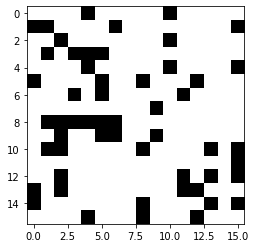

In [253]:
gridworld, start, end, optimal_path = generate_solvable_gridworld(16, prob=0.8)
gridworld = np.array(gridworld) * 1.0
print(gridworld)
print("start:", start)
print("end:", end)

plt.imshow(gridworld, cmap='gray')
plt.show()

In [205]:
visited_mark = 0.8  # Cells visited by the rat will be painted by gray 0.8
end_mark = 1.5
rat_mark = 0.5      # The current rat cell will be painteg by gray 0.5
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3

# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

num_actions = len(actions_dict)

maze_path = 'maze8n_4.txt'# 'maze8n_4.txt'  # 'games/GridWorld/maze16_0.05_1.txt'  # maze16_0.05_1.txt
ob_size = 3  # -1:全局, N*N
ENV_NAME = 'grid_'+maze_path.split('.txt')[0]

# BATCH_SIZE是指从重放缓冲区采样的转换数
# GAMMA是上一节中提到的折扣系数
# EPS_START是EPSILON的起始值
# EPS_END是epsilon的最终值
# EPS_DECAY 控制epsilon的指数衰减率，越高意味着衰减越慢
# TAU是目标网络的更新率
# LR是AdamW优化器的学习率
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.95
EPS_END = 0.05
EPS_DECAY = 20000
TAU = 0.005
LR = 1e-3
num_episodes = 500
max_Tstep = 3200  # 8000 320000
sync_target_net_freq = 1e4 # -1 1e4

R_GOAL = 50
R_WALL = -10
R_MOVE = 0
R_Heuristic = True

In [206]:
# now = time.strftime("%m-%d_%H-%M-%S", time.localtime())
# folder_name = f"runs/{ENV_NAME}/" + now
# os.makedirs('runs/', exist_ok=True)
# os.makedirs(f'runs/{ENV_NAME}/', exist_ok=True)
# os.makedirs(folder_name, exist_ok=True)

In [207]:
import random
import heapq

def find_path(maze, start, end):
    """
    使用 A* 算法搜索迷宫最优路径
    :param maze: 二维迷宫数组，0 表示障碍，1 表示可通行
    :param start: 起点坐标 (row, col)
    :param end: 终点坐标 (row, col)
    :return: 返回最优路径
    """
    ROW, COL = len(maze), len(maze[0])
    pq = []  # 使用优先队列存储搜索节点
    heapq.heappush(pq, (0, start, [start]))
    visited = set()  # 使用 set 存储已访问的节点
    while pq:
        f, (row, col), path = heapq.heappop(pq)
        if (row, col) in visited:
            continue
        visited.add((row, col))
        if (row, col) == end:
            return path
        for (r, c) in [(row-1, col), (row+1, col), (row, col-1), (row, col+1)]:
            if 0 <= r < ROW and 0 <= c < COL and maze[r][c] == 1 and (r, c) not in visited:
                g = len(path)  # 当前节点到起点的距离
                h = abs(r-end[0]) + abs(c-end[1])  # 当前节点到终点的曼哈顿距离
                f = g + h
                heapq.heappush(pq, (f, (r, c), path + [(r, c)]))
    return False

## Q-maze

In [208]:
# maze is a 2d Numpy array of floats between 0.0 to 1.0
# 1.0 corresponds to a free cell, and 0.0 an occupied cell
# rat = (row, col) initial rat position (defaults to (0,0))

class Qmaze(object):
    def __init__(self, maze, ob_size, rat=(0,0), max_Tstep=800):
        # 允许的最大步数
        self.max_Tstep = max_Tstep
        self.action_space = [0, 1, 2, 3]
        # 初始化迷宫，老鼠可以从任意位置开始，默认为左上角
        self._maze = np.array(maze)
        nrows, ncols = self._maze.shape
        # 终点始终在右下角
        self.target = (nrows-1, ncols-1)   # target cell where the "cheese" is
        # 初始化空格list，maze为1表示空格，为0表示墙体
        self.free_cells = [(r,c) for r in range(nrows) for c in range(ncols) if self._maze[r,c] == 1.0]
        # 将目标格移出空格list
        self.free_cells.remove(self.target)
        # 检查左上和右下是否为空
        if self._maze[self.target] == 0.0:
            raise Exception("Invalid maze: target cell cannot be blocked!")
        if not rat in self.free_cells:
            raise Exception("Invalid Rat Location: must sit on a free cell")
        # 决定观测范围，-1为全局观测
        self.ob_size = ob_size
        # 放置老鼠并初始化参数
        state, info = self.reset(rat)
    
        # return state, info

    def reset(self, rat=(0, 0)):
        self.rat = rat
        self.maze = np.copy(self._maze)
        nrows, ncols = self.maze.shape
        row, col = rat
        self.maze[row, col] = rat_mark
        self.maze[self.target[0], self.target[1]] = end_mark
        # 初始状态
        self.state = (row, col, 'start')
        # 设置最低奖励阈值
        self.min_reward = -800 # -0.5 * self.maze.size
        # 初始化总奖励
        self.total_reward = 0
        self.visited = list()
        self.total_Tstep = 0
        
        return self.observe(), self.game_status()

    def update_state(self, action):
        '''
            input: action [0, 1, 2, 3] [L, U, R, D]
        '''
        nrows, ncols = self.maze.shape
        nrow, ncol, nmode = rat_row, rat_col, mode = self.state
        
        # 如果老鼠访问的是空格，则记录
        if self.maze[rat_row, rat_col] > 0.0:
            self.visited.append((rat_row, rat_col))  # mark visited cell

        # 获取所有可能执行的动作
        valid_actions = self.valid_actions()
        # print('valid_actions', valid_actions)
        
        # 如果没有可以执行的动作（被围住了），则状态为 blocked，位置不变
        if not valid_actions:
            nmode = 'blocked'
            print('blocked')
        # 如果需要执行的动作在可执行动作列表中，那么状态为有效，并相应执行动作
        elif action in valid_actions:
            nmode = 'valid'
            if action == LEFT:
                ncol -= 1
            elif action == UP:
                nrow -= 1
            if action == RIGHT:
                ncol += 1
            elif action == DOWN:
                nrow += 1
        # 如果需要执行的动作不在可执行动作列表中（撞墙），位置不变
        else:                  # invalid action, no change in rat position
            nmode = 'invalid'
            
        self.total_Tstep += 1  # 每次执行动作+1
        # new state
        self.state = (nrow, ncol, nmode)

    def get_reward(self):
        rat_row, rat_col, mode = self.state
        nrows, ncols = self.maze.shape
        
        reward = 0
        rl = 0
        rg = 0
        
        if rat_row == nrows-1 and rat_col == ncols-1:
            rl = R_GOAL  # 奶酪，给予 1.0 分
        # elif mode == 'blocked':
        #     rl = self.min_reward - 1
        # elif (rat_row, rat_col) in self.visited:
        #     rl = -0.25  # 访问已经访问过的单元格，-0.25 分
        elif mode == 'invalid':
            rl = R_WALL  # 撞墙-0.75 分，动作不会被执行
        elif mode == 'valid':
            rl = R_MOVE  # 每次移动都会花费老鼠 -0.04 分
            
        if R_Heuristic:
            rg = - (abs(self.state[0]-self.target[0]) + abs(self.state[1]-self.target[1]))
#             print(rl, rg)
        
        reward = rl + rg
        
        return reward

    def act(self, action):
        self.update_state(action)
        reward = self.get_reward()
        self.total_reward += reward
        status = self.game_status()
        envstate = self.observe()
        return envstate, reward, status
    
    def step(self, action):
        envstate, reward, status = self.act(action)
        observation = envstate
        done = self.is_game_done()
        info = status
        return observation, reward, done, info

    def observe(self):
        if self.ob_size == -1:
            canvas = self.draw_env()
        else:
            canvas = self.get_observation()
        envstate = canvas.reshape((1, -1))
        return envstate

    def draw_env(self):
        canvas = np.copy(self.maze)
        nrows, ncols = self.maze.shape
        # clear all visual marks
        for r in range(nrows):
            for c in range(ncols):
                if canvas[r,c] > 0.0:
                    canvas[r,c] = 1.0
        # draw the rat
        row, col, valid = self.state
        canvas[row, col] = rat_mark
        canvas[self.target[0], self.target[1]] = end_mark
        return canvas

    def game_status(self):
#         if self.total_Tstep > self.max_Tstep or self.total_reward < self.min_reward:
        # if self.total_reward < self.min_reward:
        if self.total_Tstep > self.max_Tstep:
            return 'lose'
        rat_row, rat_col, mode = self.state
        nrows, ncols = self.maze.shape
        if rat_row == nrows-1 and rat_col == ncols-1:
            self.visited.append((rat_row, rat_col))  # mark visited cell
            return 'win'

        return 'not_over'
    
    def is_game_done(self):
        game_status = self.game_status()
        
        if game_status == 'not_over':
            return False
        elif game_status == 'win' or game_status == 'lose':
            return True
        
        return -1

    def valid_actions(self, cell=None):
        # 默认验证当前位置
        if cell is None:
            row, col, mode = self.state
        else:
            row, col = cell
        actions = copy.deepcopy(self.action_space)
        nrows, ncols = self.maze.shape
        # 如果在第0行，则不能向上走；如果在最后一行，则不能向下走
        if row == 0:
            actions.remove(1)
        elif row == nrows-1:
            actions.remove(3)
        # 列-左右
        if col == 0:
            actions.remove(0)
        elif col == ncols-1:
            actions.remove(2)

        # 如果不在最左列，而左边是墙，则不能向左；右边同理
        if row>0 and self.maze[row-1,col] == 0.0:
            actions.remove(1)
        if row<nrows-1 and self.maze[row+1,col] == 0.0:
            actions.remove(3)

        # 上下同理
        if col>0 and self.maze[row,col-1] == 0.0:
            actions.remove(0)
        if col<ncols-1 and self.maze[row,col+1] == 0.0:
            actions.remove(2)

        # 返回所有可能执行的动作
        return actions
    
    def get_observation(self):
        size = self.ob_size
        maze = self.draw_env()
        row, col, _ = self.state
        # 获取maze的行列数
        ROWS = len(maze)
        COLS = len(maze[0])

        # 初始化结果二维数组
        result = [[0 for _ in range(size)] for _ in range(size)]

        # 将以指定点为中心指定尺寸范围的观测值存入结果二维数组
        for i in range(row-size//2, row+size//2+1):
            for j in range(col-size//2, col+size//2+1):
                if i < 0 or i >= ROWS or j < 0 or j >= COLS:
                    # 如果超出边界，则填充为1
                    result[i-row+size//2][j-col+size//2] = 0.0
                else:
                    result[i-row+size//2][j-col+size//2] = maze[i][j]

        # 返回结果二维数组
        result = np.array(result)
        result[size//2][size//2] = 0.5
        return result

In [209]:
def show(qmaze):
    plt.grid('on')
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(qmaze.maze)
    for row,col in qmaze.visited:
        canvas[row,col] = 0.6
    rat_row, rat_col, _ = qmaze.state
    canvas[rat_row, rat_col] = 0.3   # rat cell
    canvas[nrows-1, ncols-1] = 0.9 # cheese cell
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    return img

In [268]:
# np.savetxt('maze32_1.txt', maze)
# 读取迷宫
# maze = np.loadtxt(maze_path)
# maze = maze*0+1.0
maze = gridworld*1.0

optimal path length is: 31
[[0.  0.  0.  0.  0.5 1.  0.  0.  0. ]]


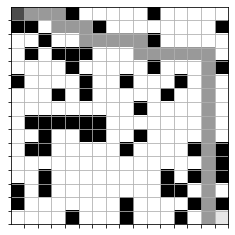

In [269]:
# 测试读取的迷宫，并获得最优长度optimal_length
qmaze = Qmaze(maze, ob_size=ob_size)
maze_size = maze.shape[0]
optimal_path = find_path(maze, (0, 0), (maze_size-1, maze_size-1))
qmaze.visited = optimal_path
optimal_length = len(optimal_path)

show(qmaze)
print('optimal path length is:', optimal_length)
# 测试观测
print(qmaze.observe())

## DQN

In [270]:
import math
import torch
import torch.nn as nn
import torch.optim as optim

class DQN(nn.Module):
    def __init__(self, observation_size, num_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(observation_size, 32)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(32, 32)
        self.relu2 = nn.ReLU()
        self.output_layer = nn.Linear(32, num_actions)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.relu1(x)
        x = self.layer2(x)
        x = self.relu2(x)
        x = self.output_layer(x)
        return x


In [271]:
from collections import namedtuple, deque
import matplotlib
import matplotlib.pyplot as plt
# set up matplotliba
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
    
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)
    
# def plot_rewards(episode_rewards, show_result=False, zero_point=None, ylabel='Rewards'):
#     plt.figure(1)
#     rewards_t = torch.tensor(episode_rewards, dtype=torch.float)
#     if show_result:
#         plt.title('Result')
#     else:
#         plt.clf()
#         plt.title('Training...')
#     plt.xlabel('Episode')
#     plt.ylabel(ylabel)
#     plt.plot(rewards_t.numpy())
    
#     if zero_point is None:
#         zero_point = (maze_size*maze_size*0.5)
    
#     # Take 100 episode averages and plot them too
#     if len(rewards_t) >= 100:
#         means = rewards_t.unfold(0, 100, 1).mean(1).view(-1)
#         means = torch.cat((torch.zeros(99)-zero_point, means))
#         plt.plot(means.numpy())

#     plt.pause(0.001)  # pause a bit so that plots are updated
#     if is_ipython:
#         if not show_result:
#             display.display(plt.gcf())
#             display.clear_output(wait=True)
#         else:
#             display.display(plt.gcf())

def moving_average(data_list, window_size=100):
    moving_averages = []
    for i in range(len(data_list)):
        if i < window_size:
            window_data = data_list[:i + 1]
        else:
            window_data = data_list[i - window_size + 1:i + 1]
        average = sum(window_data) / len(window_data)
        moving_averages.append(average)
    
    return moving_averages


def plot_rewards(episode_rewards, show_result=False, ylabel='Rewards', window_size=100, maze_size=8):
    plt.figure(1)
    rewards_t = np.array(episode_rewards)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel(ylabel)
    plt.plot(rewards_t)
    
    # Compute the moving average with the specified window size and plot it
    moving_averages = moving_average(episode_rewards, window_size)
    plt.plot(moving_averages)
    
    if ylabel == 'Rewards':
        if maze_size == 16:
            plt.axhline(y=-385, color='Red', linestyle='--')  # 
            plt.ylim([-385*10, -385*0.8])
#             plt.ylim([-500, 55])
        elif maze_size == 8:
            plt.axhline(y=50, color='Red', linestyle='--')
            plt.ylim([-200, 55])
    if ylabel == 'win_eval':
        plt.ylim([0, 1.1])

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())  # "get current figure"（获取当前图形）
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())



In [272]:
# 动作选取
def select_action(state):
    global steps_done
    sample = random.random()
    
    # 随着进行，eps_threshold逐渐降低
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
#     eps_threshold = 0.1
    steps_done += 1
    
    # 常规情况选择价值最高的动作
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    
    # 当随机值超过阈值时，随机选取 - exploration
    else:
        # 探索时只探索可能的动作，增加探索效率？
        return torch.tensor([[random.choice(env.valid_actions())]], device=device, dtype=torch.long)

In [273]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    
    # 离线学习，从记忆池中抽取回忆
    transitions = memory.sample(BATCH_SIZE)

    # 将([a, 1], [b, 2], [c, 3])转化为([a, b, c], [1, 2, 3])，一个zip的trick
    # 然后将他们分别放到tuples with names里（'state', 'action', 'next_state', and 'reward'）
    batch = Transition(*zip(*transitions))

    # 计算非最终状态的掩码，并将批处理元素连接起来
    # (最终状态是指模拟结束后的状态)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # 模型计算Q价值，我们根据价值选择动作
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]

    # 当前奖励+下一个状态的奖励，更新Q. 如果下一个状态为最终状态，则仅有当前奖励
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch  

    # Compute Huber loss
#     criterion = nn.SmoothL1Loss()
    criterion = nn.MSELoss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
#     torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()
    
    return loss.item()

# optimize_model()

In [274]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'

In [275]:
# ss = []
# es = []
# EPS_DECAY = 10
# for i in range(1000):
#     sample = random.random()
#     eps_threshold = EPS_END + (EPS_START - EPS_END) * \
#             math.exp(-1. * i / EPS_DECAY)
#     # eps_threshold = 1.0 / (i + 1)
#     ss.append(sample)
#     es.append(eps_threshold)

# exploit = 0
# for i in range(1000):
#     if ss[i] > es[i]:
#         exploit += 1
# plt.plot(ss)
# plt.plot(es)
# print(exploit, exploit/1000)

In [276]:
optimal_length

31

In [277]:
from tqdm import trange

def evaluation(show_maze=False):
    global optimal_length
    win = 0
    episode_rewards_eval = []
   
    env = Qmaze(maze, ob_size, max_Tstep=optimal_length*2)

    for j in range(1):
    
        # Initialize the environment and get it's state
        state, info = env.reset()
        # Cart Position, Cart Velocity, Pole Angle, Pole Angular Velocity
        state = torch.tensor(state, dtype=torch.float32, device=device)

        done = False
        while not done:
            action = policy_net(state).max(1)[1].view(1, 1)  # 选择一个动作
            # random.choice(env.valid_actions())
            observation, reward, done, info = env.step(action.item())  # 执行动作，返回{下一个观察值、奖励、是否结束、是否提前终止}
            # reward = torch.tensor([reward], device=device)
            # print(int(action[0][0]))
            # print(observation, reward, done, info)
            # print()
            if done:
                next_state = None
            else:
                next_state = torch.tensor(observation, dtype=torch.float32, device=device)  # 如果没有终止则继续记录下一个状态

            # Store the transition in memory
            # memory.push(state, action, next_state, reward)

            # Move to the next state
            state = next_state
            
        episode_rewards_eval.append(env.total_reward)
        if info == 'win' and env.total_Tstep<=optimal_length:
            win = 1
        elif info == 'win':
            win = 0.5
        else:
            win = 0
    
    
    win_rate = win / 1
    
    if show_maze:
        show(env)
        
    # print(env.visited)
    # print(env.state)
    # print(env.total_reward)
    
    return episode_rewards_eval, win_rate, env.visited

# win_rate = evaluation(10)
# print(win_rate)

In [278]:
history = {}

In [197]:
policy_net.load_state_dict(saved_weight)

<All keys matched successfully>

In [299]:
num_episodes = 250

In [324]:
from itertools import count

steps_done = 0

# 初始化环境
env = Qmaze(maze, ob_size, max_Tstep=max_Tstep)
# 重置环境获取信息
state, info = env.reset()

n_observations = state.size
state = torch.Tensor(state).to(device)

policy_net = DQN(n_observations, num_actions).to(device)
# policy_net.load_state_dict(saved_weight)
target_net = DQN(n_observations, num_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(int(maze.size*0.5/0.04)*2)

episode_rewards = []
episode_step = []
win_eval = []
loss_train = []
val_visited_list = []
episode_rewards_eval_list = []

for i_episode in trange(num_episodes):
    # Initialize the environment and get it's state
    state, info = env.reset()
    # Cart Position, Cart Velocity, Pole Angle, Pole Angular Velocity
    state = torch.tensor(state, dtype=torch.float32, device=device)

    done = False
    for t in count():
        action = select_action(state)  # 选择一个动作
        # random.choice(env.valid_actions())
        observation, reward, done, _ = env.step(action.item())  # 执行动作，返回{下一个观察值、奖励、是否结束、是否提前终止}
        reward = torch.tensor([reward], device=device)

        if done:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device)  # 如果没有终止则继续记录下一个状态

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        loss = optimize_model()
        if loss is not None:
            loss_train.append(loss)

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        
        if sync_target_net_freq > 0:
            if (steps_done % sync_target_net_freq) == 0:
                target_net.load_state_dict(policy_net_state_dict)
        else:
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
            target_net.load_state_dict(target_net_state_dict)
        
        if done:
            break
        
#     plot_rewards(episode_rewards, False, ylabel='')
    
    episode_rewards_eval, win_rate, val_visited = evaluation()
#     if win_rate == 1:
#         break
    
    episode_rewards.append(env.total_reward)
    episode_step.append(t)
    win_eval.append(win_rate)
    episode_rewards_eval_list.append(episode_rewards_eval)
#     loss_train.append(acc_loss)
    val_visited_list.append(val_visited)
    history['episode_rewards'] = episode_rewards
    history['episode_step'] = episode_step
    history['win_eval'] = win_eval
    history['loss_train'] = loss_train
    history['val_visited_list'] = val_visited_list
    history['episode_rewards_eval_list'] = val_visited_list
    # 将字典保存成 txt 文件
#     with open(folder_name+'/history.txt', 'w') as f:
#         for key, value in history.items():
#             f.write(f'{key}: {value}\n')

100%|██████████| 250/250 [08:36<00:00,  2.06s/it]


In [325]:
np.max(episode_rewards)

-385

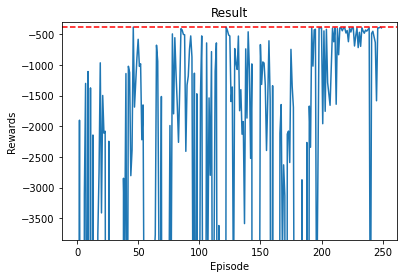

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [326]:
plot_rewards(episode_rewards, True, 'Rewards', maze_size=16)

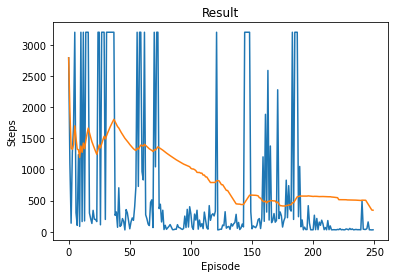

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [327]:
plot_rewards(episode_step, True, 'Steps')

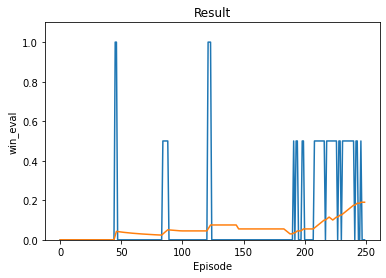

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [328]:
plot_rewards(win_eval, True, 'win_eval')

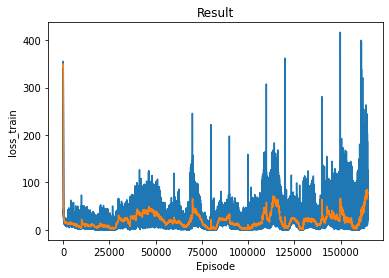

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [329]:
plot_rewards(loss_train, True, 'loss_train')

In [112]:
# EPS_DECAY

In [113]:
# ss = []
# es = []
# # EPS_DECAY = 50000
# for i in range(len(loss_train)):
#     sample = random.random()
#     eps_threshold = EPS_END + (EPS_START - EPS_END) * \
#             math.exp(-1. * i / EPS_DECAY)
#     # eps_threshold = 1.0 / (i + 1)
#     ss.append(sample)
#     es.append(eps_threshold)

# exploit = 0
# for i in range(1000):
#     if ss[i] > es[i]:
#         exploit += 1
        
# plt.scatter(list(range(len(ss))), ss, s=0.1)
# plt.plot(es, c='r',linewidth=2)

# print(exploit, exploit/1000)

In [114]:
now = time.strftime("%m-%d_%H-%M-%S", time.localtime())
save_path = f"runs/grid_8/{ENV_NAME}/" + now

In [115]:
os.makedirs(save_path, exist_ok=True)

In [116]:
cfg = {
    'visited_mark': visited_mark,
    'end_mark': end_mark,
    'rat_mark': rat_mark,
    'LEFT': LEFT,
    'UP': UP,
    'RIGHT': RIGHT,
    'DOWN': DOWN,
    'actions_dict': actions_dict,
    'num_actions': num_actions,
    'maze_path': maze_path,
    'ob_size': ob_size,
    'ENV_NAME': ENV_NAME,
    'BATCH_SIZE': BATCH_SIZE,
    'GAMMA': GAMMA,
    'EPS_START': EPS_START,
    'EPS_END': EPS_END,
    'EPS_DECAY': EPS_DECAY,
    'TAU': TAU,
    'LR': LR,
    'num_episodes': num_episodes,
    'max_Tstep': max_Tstep,
    'sync_target_net_freq': sync_target_net_freq,
    'R_GOAL': R_GOAL,
    'R_WALL': R_WALL,
    'R_MOVE': R_MOVE,
    'R_Heuristic': R_Heuristic,
}

In [117]:
# 将字典保存成 txt 文件
with open(save_path+'/config.txt', 'w') as f:
    for key, value in cfg.items():
        f.write(f'{key}: {value}\n')

In [118]:
# 将字典保存成 txt 文件
with open(save_path+'/history.txt', 'w') as f:
    for key, value in history.items():
        f.write(f'{key}: {value}\n')

In [119]:
print(cfg)

{'visited_mark': 0.8, 'end_mark': 1.5, 'rat_mark': 0.5, 'LEFT': 0, 'UP': 1, 'RIGHT': 2, 'DOWN': 3, 'actions_dict': {0: 'left', 1: 'up', 2: 'right', 3: 'down'}, 'num_actions': 4, 'maze_path': 'maze8n_4.txt', 'ob_size': 3, 'ENV_NAME': 'grid_maze8n_4', 'BATCH_SIZE': 128, 'GAMMA': 0.99, 'EPS_START': 0.95, 'EPS_END': 0.05, 'EPS_DECAY': 20000, 'TAU': 0.005, 'LR': 0.001, 'num_episodes': 500, 'max_Tstep': 320000, 'sync_target_net_freq': 10000.0, 'R_GOAL': 50, 'R_WALL': -10, 'R_MOVE': 0, 'R_Heuristic': True}


In [120]:
save_weight = torch.save(policy_net, save_path + '/agent_policy.pth')

In [121]:
saved_weight = copy.deepcopy(policy_net.state_dict())

In [830]:
# def display_maze_and_path(maze, path):
#     # Create a grid with obstacles, visited cells, rat and end positions
#     grid_with_path = maze.copy()

#     # Mark the visited cells and path positions
#     for position in path:
#         if grid_with_path[position] == 1:  # Check if it's a free cell
#             grid_with_path[position] = visited_mark-0.3

#     # Mark the start (rat) and end positions
#     start, end = path[0], (7, 7)
#     grid_with_path[start] = rat_mark
#     grid_with_path[end] = end_mark
#     print(grid_with_path)

#     # Display the grid
#     plt.imshow(grid_with_path, cmap="coolwarm")
#     plt.colorbar()
#     plt.show()

In [831]:
# def display_maze_and_path(maze, path):
#     # Switch 0 and 1 in the maze
# #     maze = 1 - maze
    
#     visited_mark = 0.6  # Cells visited by the rat will be painted by gray 0.6
#     end_mark = 0.8
#     rat_mark = 0.4      # The current rat cell will be painted by gray 0.4

#     # Create a grid with obstacles, visited cells, rat and end positions
#     grid_with_path = maze.copy()

#     # Initialize a visits grid
#     visits_grid = np.zeros(maze.shape, dtype=int)

#     # Mark the visited cells and path positions
#     for position in path:
#         if grid_with_path[position] == 1:  # Check if it's a free cell
#             visits_grid[position] += 1

#     # Normalize the visits grid to a range between visited_mark and rat_mark
#     print(visits_grid)
#     visits_grid = (visits_grid / (visits_grid.max()/0.9))
# #     print(visits_grid)

#     # Overlay the visits grid on the maze
# #     grid_with_path[np.where(visits_grid > visited_mark)] = visits_grid[np.where(visits_grid > visited_mark)]
#     grid_with_path += visits_grid
# #     print(grid_with_path)

#     # Mark the start (rat) and end positions
#     start, end = path[0], (15, 15)
# #     grid_with_path[start] = 0.1
#     grid_with_path[end] = 0.9
# #     print(grid_with_path)

#     # Display the grid
#     plt.imshow(grid_with_path, cmap="gray")  # coolwarm
#     plt.colorbar()
#     plt.show()

In [309]:
def visualize_path(maze_size, path):
    grid = np.zeros((maze_size, maze_size))
    plt.figure(figsize=(maze_size/2, maze_size/2))

    for index, position in enumerate(path[:-1]):
        plt.plot([position[1], path[index + 1][1]], [position[0], path[index + 1][0]], color='blue', linewidth=2)

    plt.plot(0, 0, 'go', markersize=10, label='Start')  # start point
    plt.plot(maze_size - 1, maze_size - 1, 'ro', markersize=10, label='Goal')  # goal point
    plt.legend()
    plt.xticks(range(maze_size))
    plt.yticks(range(maze_size))
    plt.grid(True)
    plt.gca().invert_yaxis()
    plt.show()

In [310]:
# Find the indices of all 1's in the data_list
indices_of_ones = [i for i, value in enumerate(win_eval) if value == 1]

print(indices_of_ones)

[]


In [311]:
# Find the indices of all 1's in the data_list
indices_of_ones = [i for i, value in enumerate(win_eval) if value > 0 and value < 1]

print(indices_of_ones)

[142, 186, 187]


In [312]:
# Find the indices of all 1's in the data_list
indices_of_ones = [i for i, value in enumerate(win_eval) if value == 1]

print(indices_of_ones)

[]


In [315]:
path = history['val_visited_list'][142]
print(path)

[(0, 0), (0, 1), (0, 2), (1, 2), (1, 3), (1, 4), (2, 4), (2, 5), (2, 6), (3, 6), (4, 6), (4, 7), (4, 8), (4, 9), (3, 9), (3, 10), (3, 11), (3, 12), (4, 12), (4, 13), (5, 13), (6, 13), (6, 14), (7, 14), (8, 14), (9, 14), (10, 14), (11, 14), (12, 14), (13, 14), (14, 14), (15, 14), (15, 15), (15, 15)]


In [316]:
def visualize_path(maze, path):
    maze_size = len(maze)
    plt.figure(figsize=(maze_size/2, maze_size/2))

    # Draw obstacles
    for i in range(maze_size):
        for j in range(maze_size):
            if maze[i][j] == 0:
                plt.fill_between([j-.5, j+1-.5], i-.5, i+1-.5, color='black')

    # Draw the path
    for index, position in enumerate(path[:-1]):
        plt.plot([position[1], path[index + 1][1]], [position[0], path[index + 1][0]], color='blue', linewidth=2)

    plt.plot(0, 0, 'go', markersize=10, label='Start')  # start point
    plt.plot(maze_size - 1, maze_size - 1, 'ro', markersize=10, label='Goal')  # goal point
    plt.legend()
    plt.xticks(range(maze_size))
    plt.yticks(range(maze_size))
    plt.grid(True)
    plt.gca().invert_yaxis()
    plt.show()


Steps: 34


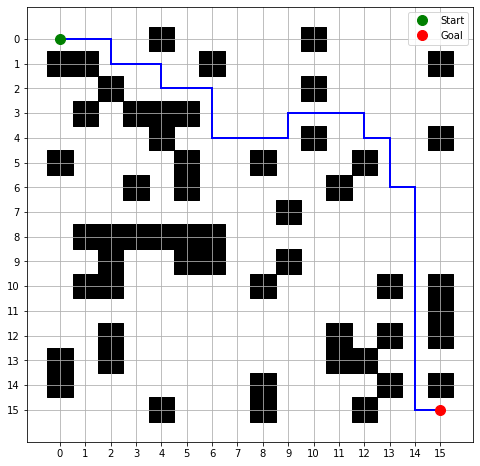

In [317]:
# maze_size = 8
print("Steps:", len(path))
visualize_path(maze, path)

In [855]:
len(episode_rewards)

500

In [754]:
# Initialize the environment and get it's state
state, info = env.reset()
# Cart Position, Cart Velocity, Pole Angle, Pole Angular Velocity
state = torch.tensor(state, dtype=torch.float32, device=device)

done = False
while not done:
    print(state)
    action = policy_net(state).max(1)[1].view(1, 1)  # 选择一个动作
    # random.choice(env.valid_actions())
    observation, reward, done, _ = env.step(action.item())  # 执行动作，返回{下一个观察值、奖励、是否结束、是否提前终止}
    # reward = torch.tensor([reward], device=device)

    if done:
        next_state = None
    else:
        next_state = torch.tensor(observation, dtype=torch.float32, device=device)  # 如果没有终止则继续记录下一个状态

    # Store the transition in memory
    # memory.push(state, action, next_state, reward)

    # Move to the next state
    state = next_state
    

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 1.0000, 0.0000, 1.0000, 1.0000]],
       device='cuda:0')
tensor([[0.0000, 1.0000, 1.0000, 0.0000, 0.5000, 1.0000, 0.0000, 1.0000, 1.0000]],
       device='cuda:0')
tensor([[1.0000, 1.0000, 1.0000, 1.0000, 0.5000, 1.0000, 1.0000, 1.0000, 1.0000]],
       device='cuda:0')
tensor([[1.0000, 1.0000, 1.0000, 1.0000, 0.5000, 1.0000, 1.0000, 1.0000, 1.0000]],
       device='cuda:0')
tensor([[1.0000, 1.0000, 1.0000, 1.0000, 0.5000, 1.0000, 1.0000, 1.0000, 1.0000]],
       device='cuda:0')
tensor([[1.0000, 1.0000, 1.0000, 1.0000, 0.5000, 1.0000, 1.0000, 1.0000, 1.0000]],
       device='cuda:0')
tensor([[1.0000, 1.0000, 1.0000, 1.0000, 0.5000, 1.0000, 1.0000, 1.0000, 1.0000]],
       device='cuda:0')
tensor([[1.0000, 1.0000, 1.0000, 1.0000, 0.5000, 1.0000, 1.0000, 1.0000, 1.0000]],
       device='cuda:0')
tensor([[1.0000, 1.0000, 1.0000, 1.0000, 0.5000, 1.0000, 1.0000, 1.0000, 1.0000]],
       device='cuda:0')
tensor([[1.0000, 1.0000, 1.0000, 1.00

[(0, 0), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (2, 15), (3, 15), (4, 15), (5, 15), (6, 15), (7, 15), (8, 15), (9, 15), (10, 15), (11, 15), (12, 15), (13, 15), (14, 15), (15, 15), (15, 15)]
50


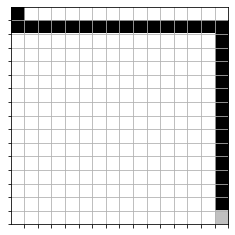

In [753]:
show(env)
print(env.visited)
print(env.total_reward)

In [757]:
policy_net.cpu()

DQN(
  (layer1): Linear(in_features=9, out_features=128, bias=True)
  (relu1): ReLU()
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (relu2): ReLU()
  (output_layer): Linear(in_features=128, out_features=4, bias=True)
)

In [ ]:
# Actions dictionary
actions_dict = {
    LEFT: 'left',  # 0
    UP: 'up',      # 1
    RIGHT: 'right',# 2
    DOWN: 'down',  # 3
}

In [778]:
# step 0
step_0_state = torch.Tensor([[0, 0, 0, 0, 0.5, 1, 0, 1, 1]])
policy_net(step_0_state).max(1)[1].view(1, 1)

tensor([[3]])

In [779]:
# step 1
step_1_state = torch.Tensor([[0, 1, 1, 0, 0.5, 1, 0, 1, 1]])
policy_net(step_1_state).max(1)[1].view(1, 1)

tensor([[2]])

In [788]:
# step 2
step_2_state = torch.Tensor([[1, 1, 1, 1, 0.5, 1, 1, 1, 1]])
policy_net(step_1_state).max(1)[1].view(1, 1)

tensor([[3]])

In [780]:
# step 16
step_16_state = torch.Tensor([[1, 1, 0, 1, 0.5, 0, 1, 1, 0]])
policy_net(step_16_state).max(1)[1].view(1, 1)

tensor([[3]])

In [781]:
# step 29
step_29_state = torch.Tensor([[1, 1, 0, 1, 0.5, 0, 1, 1.5, 0]])
policy_net(step_29_state).max(1)[1].view(1, 1)

tensor([[3]])

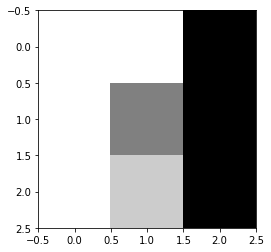

In [797]:
step_29_state = torch.Tensor([[1, 1, 0, 1, 0.5, 0, 1, 0.8, 0]])
state = step_29_state.reshape((3, 3))
plt.imshow(state, cmap='gray')

In [ ]:
# history['test_route'] = env.visited
# history['test_total_reward'] = env.total_reward

# # 将字典保存成 txt 文件
# with open(folder_name+'/history.txt', 'w') as f:
#     for key, value in history.items():
#         f.write(f'{key}: {value}\n')

# torch.save(policy_net.state_dict(), folder_name+'/my_model_weights.pth')

In [ ]:
# env.total_Tstep

In [ ]:
# ! jupyter nbconvert --to python GridWorld_report.ipynb

In [37]:
import numpy as np
import random

def random_move(position, maze_size):
    move = random.choice(['up', 'down', 'left', 'right'])
    new_position = position

    if move == 'up' and position[0] > 0:
        new_position = (position[0] - 1, position[1])
    elif move == 'down' and position[0] < maze_size - 1:
        new_position = (position[0] + 1, position[1])
    elif move == 'left' and position[1] > 0:
        new_position = (position[0], position[1] - 1)
    elif move == 'right' and position[1] < maze_size - 1:
        new_position = (position[0], position[1] + 1)

    return new_position

def random_explore(maze_size):
    start = (0, 0)
    goal = (maze_size - 1, maze_size - 1)
    position = start
    path = [start]
    steps = 0

    while position != goal:
        position = random_move(position, maze_size)
        path.append(position)
        steps += 1

    return path, steps

maze_size = 16
path, steps = random_explore(maze_size)
print("Path:", path)
print("Steps:", steps)


Path: [(0, 0), (0, 0), (0, 1), (0, 1), (0, 0), (0, 0), (0, 1), (0, 0), (0, 1), (1, 1), (1, 2), (1, 1), (1, 2), (1, 1), (1, 2), (2, 2), (1, 2), (2, 2), (3, 2), (3, 3), (2, 3), (3, 3), (4, 3), (5, 3), (5, 2), (5, 1), (5, 2), (6, 2), (6, 1), (7, 1), (7, 0), (7, 0), (7, 1), (6, 1), (6, 0), (6, 0), (5, 0), (5, 0), (5, 0), (4, 0), (4, 1), (5, 1), (4, 1), (4, 0), (3, 0), (4, 0), (4, 1), (4, 0), (3, 0), (3, 1), (3, 2), (2, 2), (3, 2), (3, 3), (3, 4), (3, 3), (4, 3), (5, 3), (5, 2), (6, 2), (5, 2), (4, 2), (5, 2), (5, 1), (4, 1), (3, 1), (4, 1), (4, 0), (4, 1), (3, 1), (3, 2), (4, 2), (5, 2), (5, 3), (5, 4), (5, 3), (6, 3), (6, 2), (6, 1), (7, 1), (7, 0), (6, 0), (5, 0), (6, 0), (5, 0), (4, 0), (5, 0), (6, 0), (7, 0), (7, 0), (8, 0), (9, 0), (9, 1), (9, 2), (9, 1), (9, 0), (10, 0), (10, 1), (10, 2), (9, 2), (9, 3), (9, 4), (9, 3), (8, 3), (8, 4), (9, 4), (10, 4), (10, 3), (10, 4), (11, 4), (12, 4), (11, 4), (11, 3), (11, 4), (12, 4), (12, 3), (13, 3), (14, 3), (14, 4), (15, 4), (14, 4), (14, 3)

Steps: 546


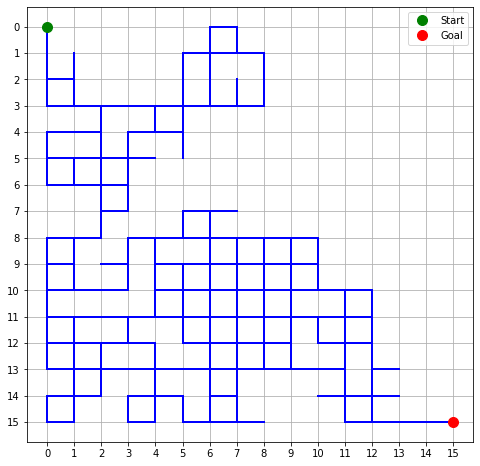

In [664]:
import numpy as np
import random
import matplotlib.pyplot as plt

def random_move(position, maze_size):
    move = random.choice(['up', 'down', 'left', 'right'])
    new_position = position

    if move == 'up' and position[0] > 0:
        new_position = (position[0] - 1, position[1])
    elif move == 'down' and position[0] < maze_size - 1:
        new_position = (position[0] + 1, position[1])
    elif move == 'left' and position[1] > 0:
        new_position = (position[0], position[1] - 1)
    elif move == 'right' and position[1] < maze_size - 1:
        new_position = (position[0], position[1] + 1)

    return new_position

def random_explore(maze_size):
    start = (0, 0)
    goal = (maze_size - 1, maze_size - 1)
    position = start
    path = [start]
    steps = 0

    while position != goal:
        position = random_move(position, maze_size)
        path.append(position)
        steps += 1

    return path, steps

def visualize_path(maze_size, path):
    grid = np.zeros((maze_size, maze_size))
    plt.figure(figsize=(maze_size/2, maze_size/2))

    for index, position in enumerate(path[:-1]):
        plt.plot([position[1], path[index + 1][1]], [position[0], path[index + 1][0]], color='blue', linewidth=2)

    plt.plot(0, 0, 'go', markersize=10, label='Start')  # start point
    plt.plot(maze_size - 1, maze_size - 1, 'ro', markersize=10, label='Goal')  # goal point
    plt.legend()
    plt.xticks(range(maze_size))
    plt.yticks(range(maze_size))
    plt.grid(True)
    plt.gca().invert_yaxis()
    plt.show()

maze_size = 16
path, steps = random_explore(maze_size)
print("Steps:", steps)
visualize_path(maze_size, path)


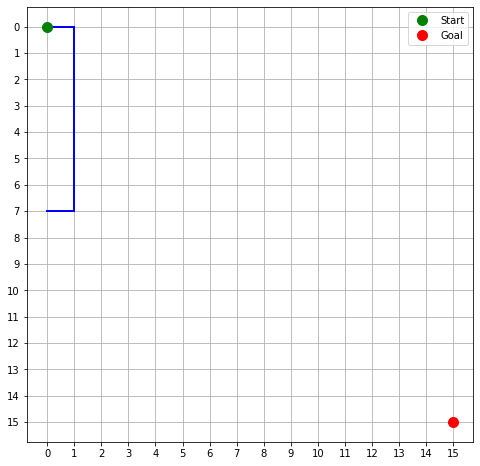

In [77]:
visualize_path(maze_size, path)

In [96]:
np.array([15, 15])-np.array([0, 0])

array([15, 15])

In [104]:
50-29*30/2

-385.0

In [143]:
win = 0
episode_rewards_eval = []

env = Qmaze(maze, ob_size, max_Tstep=optimal_length)

# for j in range(1):

# Initialize the environment and get it's state
state, info = env.reset()
#     # Cart Position, Cart Velocity, Pole Angle, Pole Angular Velocity
#     state = torch.tensor(state, dtype=torch.float32, device=device)

#     done = False
#     while not done:
        action = policy_net(state).max(1)[1].view(1, 1)  # 选择一个动作
#         # random.choice(env.valid_actions())
#         observation, reward, done, info = env.step(action.item())  # 执行动作，返回{下一个观察值、奖励、是否结束、是否提前终止}
#         # reward = torch.tensor([reward], device=device)
#         # print(int(action[0][0]))
#         # print(observation, reward, done, info)
#         # print()
#         if done:
#             next_state = None
#         else:
#             next_state = torch.tensor(observation, dtype=torch.float32, device=device)  # 如果没有终止则继续记录下一个状态

#         # Store the transition in memory
#         # memory.push(state, action, next_state, reward)

#         # Move to the next state
#         state = next_state

#     episode_rewards_eval.append(env.total_reward)
#     if info == 'win':
#         win += 1


# win_rate = win / 1

# if show_maze:
#     show(env)

# # print(env.visited)
# # print(env.state)
# # print(env.total_reward)

# return episode_rewards_eval, win_rate, env.visited